In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import json
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics, ensemble, linear_model, svm
from numpy import log, ones, array, zeros, mean, std, repeat
import numpy as np
import scipy.sparse as sp
import re
import csv
from time import time
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from textblob import TextBlob

def room_price(x, y):
    if y == 0:
        return 0
    return x/y

def get_importance(forest,features):
    #importances = forest.feature_importances_
    importance = forest.feature_importances_
    importance = pd.DataFrame(importance, index=features, 
                          columns=["Importance"])
    importance=importance.sort_values('Importance',ascending=False)
    return importance
    #features=importance[importance['Importance']].index

pd.options.display.max_columns=999
#input data
train_df=pd.read_json('../input/train.json')
test_df=pd.read_json('../input/test.json')

test_df["bathrooms"].loc[19671] = 1.5
test_df["bathrooms"].loc[22977] = 2.0
test_df["bathrooms"].loc[63719] = 2.0
train_df["price"] = train_df["price"].clip(upper=13000)


index=list(range(train_df.shape[0]))
random.shuffle(index)
a=[np.nan]*len(train_df)
b=[np.nan]*len(train_df)
c=[np.nan]*len(train_df)

for i in range(5):
    building_level={}
    for j in train_df['manager_id'].values:
        building_level[j]=[0,0,0]
    
    test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
            
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
            
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c

a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]

for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

In [2]:
train_df.shape,test_df.shape

((49352, 18), (74659, 17))

In [3]:
test_df['interest_level']='test'

In [4]:
train=pd.concat([train_df, test_df]) 
train.shape

(124011, 18)

In [5]:
fmt = lambda s: s.replace("\u00a0", "").strip().lower()
train["street_address"] = train['street_address'].apply(fmt)
train["display_address"] = train["display_address"].apply(fmt)
train.shape

(124011, 18)

In [6]:
train['num_photos'] = train['photos'].apply(len)
train['num_features'] = train['features'].apply(len)
train['num_description_words'] = train['description'].apply(lambda x: len(x.split(' ')))
train['num_description_len'] = train['description'].apply(len)

train['features'] = train["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
train.shape

(124011, 22)

In [7]:
def tfidf_feature(data_list,num_features,prefix):
    tfidf = CountVectorizer(stop_words='english', max_features=200)
    tr_sparse = tfidf.fit_transform(data_list)
    tr_sparse=pd.DataFrame(tr_sparse.todense())
    tr_sparse.columns=[prefix+str(col) for col in tr_sparse.columns]
    return tr_sparse

train=pd.concat([train,tfidf_feature(train['features'],200,'tfidf_fetures')],axis=1)
train=pd.concat([train,tfidf_feature(train['description'],100,'description_fetures')],axis=1)
train=pd.concat([train,tfidf_feature(train['street_address'],100,'street_address_fetures')],axis=1)
train=pd.concat([train,tfidf_feature(train['display_address'],100,'display_address_fetures')],axis=1)
train.shape

(124011, 822)

In [8]:
train['created'] = pd.to_datetime(train['created'])
train['date'] = train['created'].dt.date
train["year"] = train["created"].dt.year
train['month'] = train['created'].dt.month
train['day'] = train['created'].dt.day
train['hour'] = train['created'].dt.hour
train['weekday'] = train['created'].dt.weekday
train['week'] = train['created'].dt.week
train['quarter'] = train['created'].dt.quarter
train['weekend'] = ((train['weekday'] == 5) & (train['weekday'] == 6))
train['wd'] = ((train['weekday'] != 5) & (train['weekday'] != 6))
train.shape

(124011, 832)

In [9]:
from sklearn.cluster import Birch
def cluster_latlon(n_clusters, data):  
    #split the data between "around NYC" and "other locations" basically our first two clusters 
    data_c=data[(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    data_e=data[~(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    #put it in matrix form
    coords=data_c.as_matrix(columns=['latitude', "longitude"])
    
    brc = Birch(branching_factor=100, n_clusters=n_clusters, threshold=0.01,compute_labels=True)

    brc.fit(coords)
    clusters=brc.predict(coords)
    data_c["cluster_"+str(n_clusters)]=clusters
    data_e["cluster_"+str(n_clusters)]=-1 #assign cluster label -1 for the non NYC listings 
    data=pd.concat([data_c,data_e])
    #plt.scatter(data_c["longitude"], data_c["latitude"], c=data_c["cluster_"+str(n_clusters)], s=10, linewidth=0.1)
    #plt.title(str(n_clusters)+" Neighbourhoods from clustering")
    #plt.show()
    return data 

In [10]:
gpsclusters=cluster_latlon(20, train[['listing_id','latitude','longitude']])
gpsclusters=gpsclusters.drop(['latitude','longitude'],axis=1)

train["pos"] = train.longitude.round(3).astype(str) + '_' + train.latitude.round(3).astype(str)

vals = train['pos'].value_counts()
dvals = vals.to_dict()
train["density"] = train['pos'].apply(lambda x: dvals.get(x, vals.min()))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
train=pd.merge(train,gpsclusters,on='listing_id',how='left')

In [12]:
clusters_price_map=dict(train.groupby(by="cluster_20")["price"].median())
train["price_comparison"]=train['price']-train["cluster_20"].map(clusters_price_map)

In [13]:
train = train.join(
                   train['description'].apply(
                       lambda x: TextBlob(x).sentiment.polarity).rename('sentiment'))

In [14]:
train['price_room'] = train.apply(lambda row: room_price(row['price'], 
                                                         row['bedrooms']), axis=1)

train['price_bathrooms'] = train.apply(lambda row: room_price(row['price'], 
                                                         row['bathrooms']), axis=1)

In [15]:
train["room_sum"] = train["bedrooms"]+train["bathrooms"]
train['price_room_sum'] = train.apply(lambda row: room_price(row['price'], 
                                                         row['room_sum']), axis=1)

In [16]:
# Number of listings based on building ID
top_buildings = train['building_id'].value_counts().nlargest(50)
grouped_building = train.groupby(
                           ['building_id', 'interest_level']
                          )['building_id'].count().unstack('interest_level').fillna(0)

grouped_building['sum'] = grouped_building.sum(axis=1)
x = grouped_building[(grouped_building['sum'] > 50) & (grouped_building['high'] > 10)]

x['high'].plot.barh(color="palevioletred");

build_counts = pd.DataFrame(train.building_id.value_counts())
build_counts['b_counts'] = build_counts['building_id']
build_counts['building_id'] = build_counts.index
build_counts['b_count_log'] = np.log2(build_counts['b_counts'])
train = pd.merge(train, build_counts, on="building_id")

In [17]:
train.shape

(124011, 843)

In [18]:
# Hight-interest managers
top_managers = train['manager_id'].value_counts().nlargest(50)

grouped_manager = train.groupby(
    ['manager_id', 'interest_level'])['manager_id'].count().unstack('interest_level').fillna(0)

grouped_manager['sum'] = grouped_manager.sum(axis=1)


x = grouped_manager.loc[(grouped_manager['high'] > 20 ) & (grouped_manager['sum'] > 50)]


x['high'].plot.barh(figsize=(10, 9), color="teal");

man_counts = pd.DataFrame(train.manager_id.value_counts())
man_counts['m_counts'] = man_counts['manager_id']
man_counts['manager_id'] = man_counts.index
man_counts['m_count_log'] = np.log10(man_counts['m_counts'])
train = pd.merge(train, man_counts, on="manager_id")

In [19]:
# 3481 unique managers
temp = train[train.interest_level!='test'].groupby('manager_id').count().iloc[:,-1]
temp2 = train[train.interest_level=='test'].groupby('manager_id').count().iloc[:,-1]
train_managers = pd.concat([temp,temp2],axis=1,join='outer')
train_managers.columns=['train_count','test_count']

# considering only those manager_ids which are in train
man_list = train_managers['train_count'].sort_values(ascending = False).head(3481).index
ixes = train.manager_id.isin(man_list)
train10 = train[ixes][['manager_id','interest_level']]
# create dummies of interest levels
interest_dummies = pd.get_dummies(train10.interest_level)
train10 = pd.concat([train10,interest_dummies[['low','medium','high']]], axis = 1).drop('interest_level', axis = 1)

gby = pd.concat([train10.groupby('manager_id').mean(),train10.groupby('manager_id').count()], axis = 1).iloc[:,:-2]
gby.columns = ['low','medium','high','count']
gby.sort_values(by = 'count', ascending = False).head(10)
gby['manager_skill'] = gby['medium']*1 + gby['high']*2 
gby['manager_id']=gby.index


In [20]:
train = train.merge(gby[['manager_id','manager_skill']],on='manager_id',how='outer',right_index=False)
train['manager_skill']=train['manager_skill'].fillna(0)

In [21]:
train["logprice"] = np.log(train["price"])

max_date=train.created.max()

train['days_from_created']=train.created.apply(lambda x: (max_date-x).days)

In [22]:
from sklearn.preprocessing import LabelEncoder

categorical = ["display_address", "manager_id", "building_id","street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            lbl = LabelEncoder()
            lbl.fit(list(train[f].values))
            train[f] = lbl.transform(list(train[f].values))

In [23]:
def create_binary_features(df):
    bows = {
        "dogs": ("dogs", "dog"),
        "cats": ("cats",),
        "nofee": ("no fee", "no-fee", "no  fee", "nofee", "no_fee"),
        "lowfee": ("reduced_fee", "low_fee", "reduced fee", "low fee"),
        "furnished": ("furnished",),
        "parquet": ("parquet", "hardwood"),
        "concierge": ("concierge", "doorman", "housekeep", "in_super"),
        "prewar": ("prewar", "pre_war", "pre war", "pre-war"),
        "laundry": ("laundry", "lndry"),
        "health": ("health", "gym", "fitness", "training"),
        "transport": ("train", "subway", "transport"),
        "parking": ("parking",),
        "utilities": ("utilities", "heat water", "water included")
    }

    def indicator(bow):
        return lambda s: int(any([x in s for x in bow]))

    features = df["features"].apply(lambda f: " ".join(f).lower())   # convert features to string
    for key in bows:
        df["feature_" + key] = features.apply(indicator(bows[key]))

    return df

In [24]:
train=create_binary_features(train)
train.to_csv('processed_feature.csv',index=False,encoding='utf-8')

In [25]:
train.shape

(124011, 861)

In [26]:
train_df=train[train.interest_level!='test']
test_df=train[train.interest_level=='test']
train_df.loc[:,'interest_level'] = train_df['interest_level'].apply(lambda x: {'high': 0, 'medium': 1, 'low': 2}[x])

#train_df.select_dtypes(include=['bool','float64'])
train_df=train_df.select_dtypes(exclude=['O','<M8[ns]'])

features=train_df.columns.tolist()
features.remove('listing_id')
features.remove('interest_level')
features.remove('price')

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.cross_validation import train_test_split

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
forest = ExtraTreesClassifier(n_estimators=70, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['interest_level'], test_size=0.30, random_state=42)
forest.fit(X_train.fillna(0),y_train)

rf=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, min_samples_split=2, 
                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                       max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True,
                       oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)

rf.fit(X_train.fillna(0),y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [50]:
print(rf.score(X_train.fillna(0),y_train),rf.score(X_test.fillna(0),y_test))

(0.73542523012794536, 0.71673645819262466)


In [70]:
features=df[df>0].index

Populating the interactive namespace from numpy and matplotlib


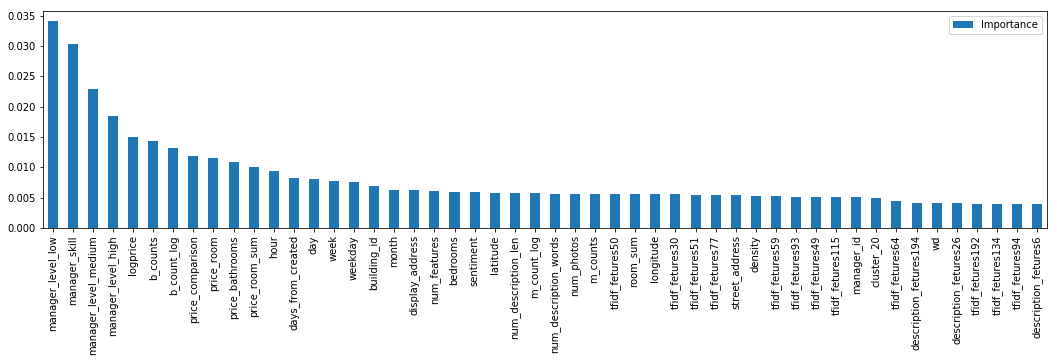

In [66]:
df=get_importance(forest,features)
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 18, 4
df.head(50).plot(kind='bar')

Populating the interactive namespace from numpy and matplotlib


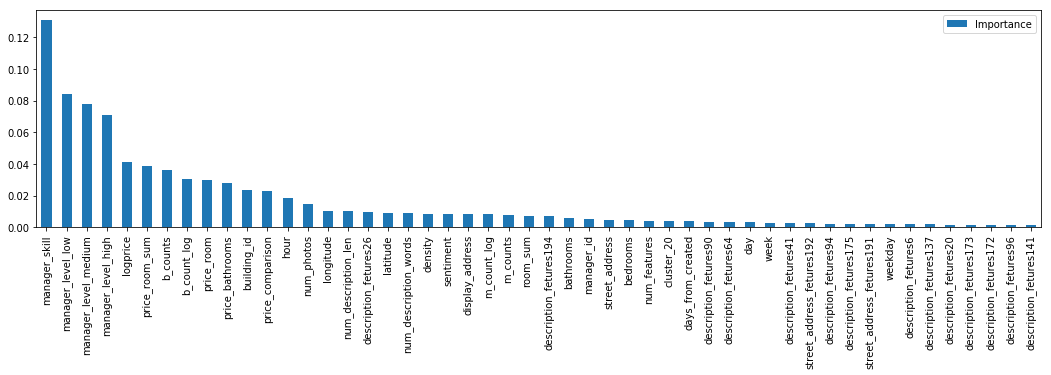

In [67]:
df=get_importance(rf,features)
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 18, 4
df.head(50).plot(kind='bar')

In [49]:
def get_importance(forest,features):
    #importances = forest.feature_importances_
    importance = forest.feature_importances_
    importance = pd.DataFrame(importance, index=features, 
                          columns=["Importance"])
    importance=importance.sort_values('Importance',ascending=False)
    return importance
    #features=importance[importance['Importance']].index

In [455]:
import lightgbm as lgbm

t4_params = {
    'boosting_type': 'gbdt', 'objective': 'multiclass', 'nthread': -1, 'silent': True,
    'num_leaves': 10, 'learning_rate': 0.03, 'max_depth': 12,
    'max_bin': 255, 'subsample_for_bin': 50000,
    'subsample': 0.6, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'reg_alpha':5, 'reg_lambda':5,
    'min_split_gain': 0.7, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}

# they can be used directly to build a LGBMClassifier (which is wrapped in a sklearn fashion)
t4 = lgbm.sklearn.LGBMClassifier(n_estimators=1000, seed=0, **t4_params)

In [456]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['interest_level'], test_size=0.30, random_state=42)
t4 = lgbm.sklearn.LGBMClassifier(n_estimators=1000, seed=0, **t4_params)
t4.fit(X_train,y_train)`
print(t4.score(X_train,y_train),t4.score(X_test,y_test))

(0.79757424882765005, 0.77063352694853438)


In [457]:
lgbm_params = t4_params.copy()
lgbm_params['num_class'] = 3
dset = lgbm.Dataset(train_df[features], train_df['interest_level'], silent=True)
cv_results = lgbm.cv(
    lgbm_params, dset, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='multi_logloss',
    early_stopping_rounds=100, verbose_eval=50, show_stdv=True, seed=0)

filename_str='lgbm_1.json'
json.dump(cv_results, open('lgbm_1.json', 'w'))
print(filename_str)
print('best n_estimators:', len(cv_results['multi_logloss-mean']))
print('best cv score:', cv_results['multi_logloss-mean'][-1])

[50]	cv_agg's multi_logloss: 0.675776 + 0.00243834
[100]	cv_agg's multi_logloss: 0.591967 + 0.00360559
[150]	cv_agg's multi_logloss: 0.564831 + 0.00422974
[200]	cv_agg's multi_logloss: 0.551815 + 0.00461705
[250]	cv_agg's multi_logloss: 0.543722 + 0.00473377
[300]	cv_agg's multi_logloss: 0.538296 + 0.00482705
[350]	cv_agg's multi_logloss: 0.534046 + 0.00488668
[400]	cv_agg's multi_logloss: 0.530649 + 0.00482355
[450]	cv_agg's multi_logloss: 0.527853 + 0.00472552
[500]	cv_agg's multi_logloss: 0.525357 + 0.00464533
[550]	cv_agg's multi_logloss: 0.523303 + 0.00461893
[600]	cv_agg's multi_logloss: 0.521465 + 0.00456813
[650]	cv_agg's multi_logloss: 0.519882 + 0.00456496
[700]	cv_agg's multi_logloss: 0.518383 + 0.00444791
[750]	cv_agg's multi_logloss: 0.517123 + 0.00435298
[800]	cv_agg's multi_logloss: 0.51605 + 0.0043669
[850]	cv_agg's multi_logloss: 0.515104 + 0.00423636
[900]	cv_agg's multi_logloss: 0.514174 + 0.00421786
[950]	cv_agg's multi_logloss: 0.513352 + 0.0041776
[1000]	cv_agg's 

In [459]:
t4 = lgbm.sklearn.LGBMClassifier(n_estimators=5446, seed=0, **t4_params)

In [461]:
t4.fit(train_df[features],train_df['interest_level'])

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.6, drop_rate=0.1,
        is_unbalance=False, learning_rate=0.03, max_bin=255, max_depth=12,
        max_drop=50, min_child_samples=10, min_child_weight=1,
        min_split_gain=0.7, n_estimators=5446, nthread=-1, num_leaves=10,
        objective='multiclass', reg_alpha=5, reg_lambda=5,
        scale_pos_weight=1, seed=0, sigmoid=1.0, silent=True,
        skip_drop=0.5, subsample=0.6, subsample_for_bin=50000,
        subsample_freq=1, uniform_drop=False, xgboost_dart_mode=False)

In [464]:
preds=t4.predict(test_df[features])
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]

In [467]:
out_df.shape,test_df[features].shape

((74659, 3), (74659, 222))

In [ ]:
out_df.loc['lab']=t4.predict(test_df[features])
out_df["listing_id"] = test_df.listing_id.values
#out_df.to_csv("sub51.csv", index=False)

In [ ]:
{'high': 0, 'medium': 1, 'low': 2}

In [71]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=321, num_rounds=2000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.02
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [72]:
preds, model = runXGB(train_df[features], train_df['interest_level'].values, test_df[features], num_rounds=2000)

In [74]:
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]

In [75]:
out_df["listing_id"] = test_df.listing_id.values

In [76]:
out_df.to_csv("xgb_123.csv", index=False)